<a href="https://colab.research.google.com/github/Norod/my-colab-experiments/blob/master/Neural_Style_Transfer_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Show System Specifications

In [1]:
from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"


print("\n\nShow Devices:\n\n"+str(device_lib.list_local_devices()))

Show System RAM Memory:


MemTotal:       13335188 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 486373493085612341
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17578392000685443742
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7012663633413153950
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14912199066
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13540095531912860741
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


# Download Dependencies to Google Colab Environment

This may take several minutes but needs to only be run once per session. Every Google Colab session has temporary storage for assets such as images and other scripts. When the session is closed these objects will be removed but the notebook will remain intact.

1.   neural_style.py
2.   ImageNet


*Run the cell below to download necessary dependencies. After this is complete you can navigate to the FILES tab on the left and select refresh - you should see the files listed.*

In [2]:
#Download neural_style.py
#This code originates from https://github.com/cysmith/neural-style-tf
!wget --output-document=neural_style.py 'https://storage.googleapis.com/marketing-files/colab-notebooks/style-transfer/neural_style.py'
 
!cat ./wget-log  
  
#Download ImageNet VGG Very Deep
#VGG-VD models from the Very Deep Convolutional Networks for Large-Scale Visual Recognition project.
!wget --output-document=imagenet-vgg-verydeep-19.mat 'https://storage.googleapis.com/marketing-files/colab-notebooks/style-transfer/imagenet-vgg-verydeep-19.mat'
 
!cat ./wget-log.1

--2020-01-22 14:11:48--  https://storage.googleapis.com/marketing-files/colab-notebooks/style-transfer/neural_style.py
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 2607:f8b0:4001:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30650 (30K) [text/x-python-script]
Saving to: ‘neural_style.py’

neural_style.py     100%[===================>]  29.93K  --.-KB/s    in 0s      

2020-01-22 14:11:48 (172 MB/s) - ‘neural_style.py’ saved [30650/30650]

cat: ./wget-log: No such file or directory
--2020-01-22 14:11:51--  https://storage.googleapis.com/marketing-files/colab-notebooks/style-transfer/imagenet-vgg-verydeep-19.mat
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 2607:f8b0:4001:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response...

# Download Style and Content Images


**download_image_from_URL()**
This function will take a URL to an image and download it so we can use it to perform a style transfer on.

**Image()** 
This function will display the image inline in the notebook and allow you to verify the image has been downloaded and is available.

*Swap out this URL with a URL of your choosing tow download specific images.*

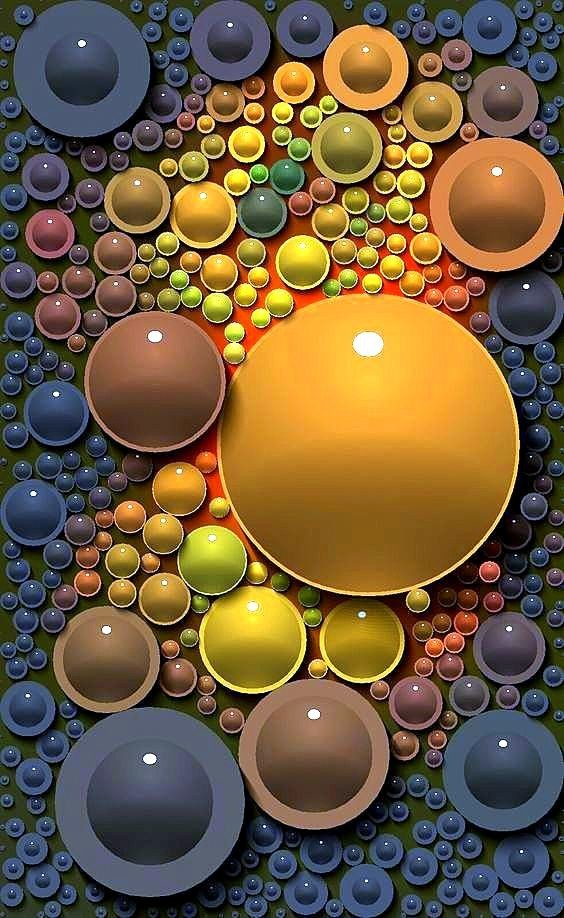

In [4]:
import re
from IPython.display import Image
import urllib

def download_image_from_URL(imageURL):
  imageName = re.search('[a-z0-9\-]+\.(jpe?g|png|gif|bmp)', imageURL, re.IGNORECASE)
  imageName = imageName.group(0)
  urllib.urlretrieve(imageURL, imageName)
  imagePath = "./" + imageName
  return imagePath
   
#Download Image from URL and Store Path in Variable

#Content image model.jpg
imageDownload1 = download_image_from_URL("https://norod78.s3-eu-west-1.amazonaws.com/img/nst/ffhq_dragon_t0008_img0002.jpg")


#Style image polygon-2.jpg
imageDownload3 = download_image_from_URL("https://norod78.s3-eu-west-1.amazonaws.com/img/nst/bubbles_style.jpg")

#Display Local Image
Image(imageDownload3)              

In [9]:
!pwd
!ls -latr




/content
total 522744
-rw-r--r-- 1 root root 534904783 Sep 18  2018 imagenet-vgg-verydeep-19.mat
-rw-r--r-- 1 root root     30650 Sep 18  2018 neural_style.py
drwxr-xr-x 1 root root      4096 Jan 13 16:38 sample_data
drwxr-xr-x 1 root root      4096 Jan 13 16:38 .config
drwxr-xr-x 1 root root      4096 Jan 22 14:10 ..
drwxr-xr-x 1 root root      4096 Jan 22 14:15 .
-rw-r--r-- 1 root root    192318 Jan 22 14:16 img0002.jpg
-rw-r--r-- 1 root root    139088 Jan 22 14:16 style.jpg


# Stylize an Image
## Single style and single content image


---- RENDERING SINGLE IMAGE ----

W0122 14:51:55.486730 140113192478592 module_wrapper.py:139] From neural_style.py:550: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

2020-01-22 14:51:55.487836: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-01-22 14:51:55.492141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-01-22 14:51:55.492644: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2020-01-22 14:51:55.492884: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-01-22 14:51:55.494252: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] S

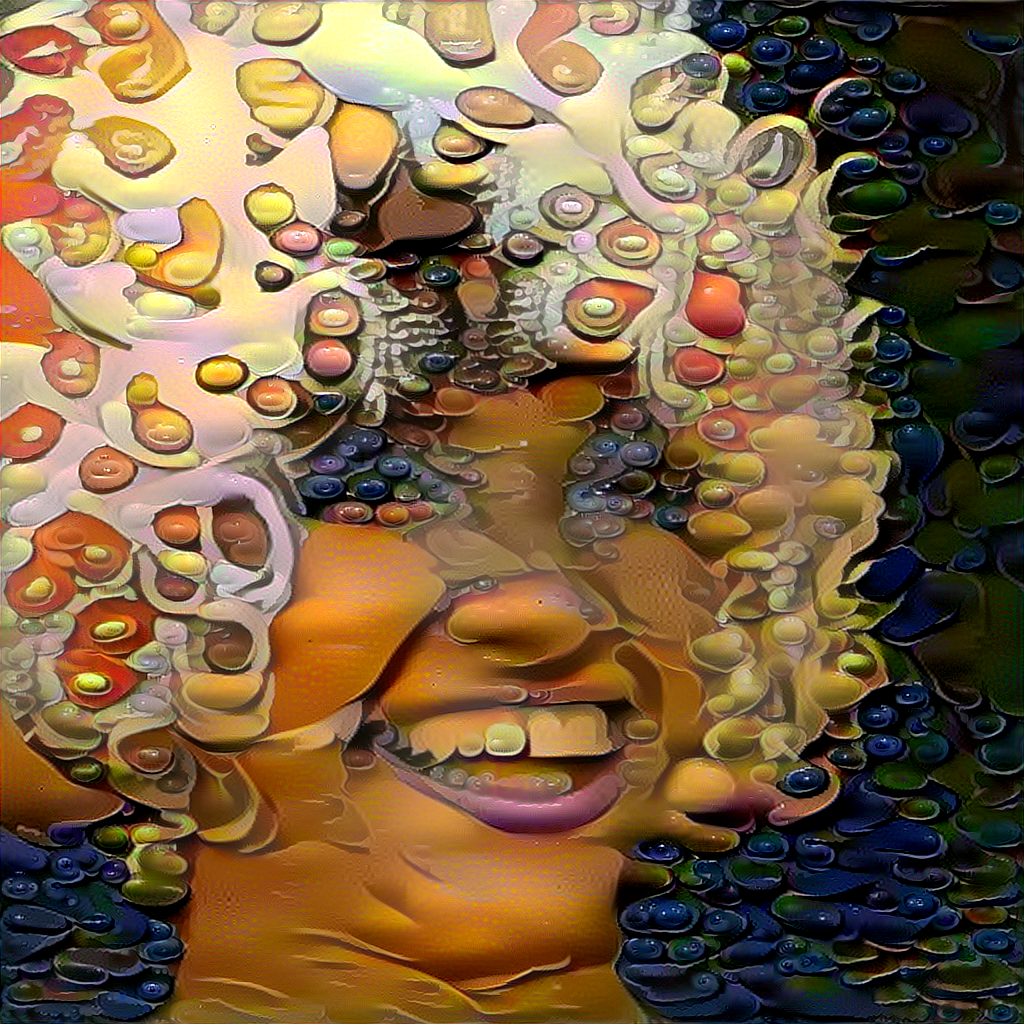

In [21]:
from IPython.display import Image


! python neural_style.py --content_img_dir ./ \
                       --content_img img0002.jpg \
                       --style_imgs_dir ./ \
                       --style_imgs style.jpg \
                       --content_weight 1 \
                       --style_weight 10000 \
                       --temporal_weight 1000 \
                       --max_iterations 180 \
                       --max_size 1024 \
                       --img_name output \
                       --device /gpu:0 \
                       --img_output_dir ./ \
                       --verbose;
                      #--original_colors \
# Print Final Image
Image('./output/output.png')

In [0]:
Additional Arguments

--content_img: Filename of the content image. Example: lion.jpg

--content_img_dir: Relative or absolute directory path to the content image. Default: ./image_input

--style_imgs: Filenames of the style images. To use multiple style images, pass a space-separated list. Example: --style_imgs starry-night.jpg

--style_imgs_weights: The blending weights for each style image. Default: 1.0 (assumes only 1 style image)

--style_imgs_dir: Relative or absolute directory path to the style images. Default: ./styles

--init_img_type: Image used to initialize the network. Choices: content, random, style. Default: content

--max_size: Maximum width or height of the input images. Default: 512

--content_weight: Weight for the content loss function. Default: 5e0

--style_weight: Weight for the style loss function. Default: 1e4

--tv_weight: Weight for the total variational loss function. Default: 1e-3

--temporal_weight: Weight for the temporal loss function. Default: 2e2

--content_layers: Space-separated VGG-19 layer names used for the content image. Default: conv4_2

--style_layers: Space-separated VGG-19 layer names used for the style image. Default: relu1_1 relu2_1 relu3_1 relu4_1 
relu5_1

--content_layer_weights: Space-separated weights of each content layer to the content loss. Default: 1.0

--style_layer_weights: Space-separated weights of each style layer to loss. Default: 0.2 0.2 0.2 0.2 0.2

--original_colors: Boolean flag indicating if the style is transferred but not the colors.

--color_convert_type: Color spaces (YUV, YCrCb, CIE L*u*v*, CIE L*a*b*) for luminance-matching conversion to original colors. Choices: yuv, ycrcb, luv, lab. Default: yuv

--style_mask: Boolean flag indicating if style is transferred to masked regions.

--style_mask_imgs: Filenames of the style mask images (example: face_mask.png). To use multiple style mask images, pass a space-separated list. Example: --style_mask_imgs face_mask.png face_mask_inv.png

--noise_ratio: Interpolation value between the content image and noise image if network is initialized with random. Default: 1.0

--seed: Seed for the random number generator. Default: 0

--model_weights: Weights and biases of the VGG-19 network. Download here. Default:imagenet-vgg-verydeep-19.mat

--pooling_type: Type of pooling in convolutional neural network. Choices: avg, max. Default: avg

--device: GPU or CPU device. GPU mode highly recommended but requires NVIDIA CUDA. Choices: /gpu:0 /cpu:0. Default: /gpu:0

--img_output_dir: Directory to write output to. Default: ./image_output

--img_name: Filename of the output image. Default: result

--verbose: Boolean flag indicating if statements should be printed to the console.
Optimization Arguments

--optimizer: Loss minimization optimizer. L-BFGS gives better results. Adam uses less memory. Choices: lbfgs, adam. Default: lbfgs

--learning_rate: Learning-rate parameter for the Adam optimizer. Default: 1e0
